# Simulating Masking Relationships
This is a simple simulation of masking relationships based on the book [Statistical Rethinking by Richard McElreath](https://xcelab.net/rm/statistical-rethinking/) chapter 5.1.

In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns
import pandas as pd
from causalgraphicalmodels import CausalGraphicalModel

The purpose of this simulation is to show that with a mutiple regression model it's possible to spot masking relationships.

This is a simulation of data, therefore, the results will be 'perfect'. It's important to keep that in mind when comparing to real world data where the coeficients will not necessarily be `0`, `0.5`, or `1` with such a small standard deviation. 

Bellow we simulate the following relationship:
<br>
**M -> K <- N**
<br>
**M -> N**

In [2]:
SAMP_SIZE = 100

# all standardised -> mean=0, std=1
M = stats.norm.rvs(size=SAMP_SIZE)
N = stats.norm.rvs(M)
K = stats.norm.rvs(N-M)

# creating a pandas dataframe
d = {'M': M,
    'N': N,
    'K': K}
df = pd.DataFrame(data=d)
df.head()

,M,N,K
0,-0.552160,-2.973466,-2.703089
1,0.526376,-0.590846,-0.943350
2,-0.657203,0.405173,0.118043
3,1.450184,0.442054,-2.449100
4,0.176077,-0.108846,-0.202482


By the pairplot bellow we can notice a clear correlation between `M` and `N`, which is expected since `N` was sampled from `M`. 
<br>
<br>
Furthermore, there's some correlation between `N` and `K` but no a clear correlation between `M` and `K`.

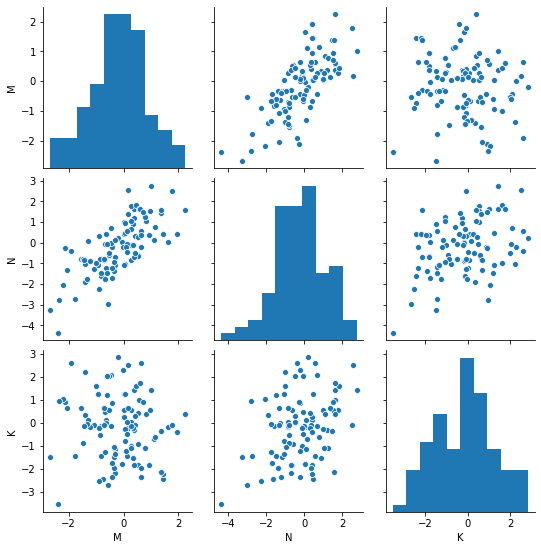

In [3]:
sns.pairplot(data=df)

In [4]:
df.corr()

,M,N,K
M,1.000000,0.721523,-0.083478
N,0.721523,1.000000,0.337846
K,-0.083478,0.337846,1.000000


### Regression  M -> K

In [5]:
with pm.Model() as mk_model:
    a = pm.Normal('a', 0, 0.2)
    bM = pm.Normal('bM', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
 
    mu = pm.Deterministic('mu', a + bM*df['M'])
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=df['K'])
    
    mk_trace = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:01<00:00, 6196.90draws/s]


In [6]:
varnames = ['~mu']
az.summary(mk_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,-0.13,0.12,-0.35,0.08
bM,-0.10,0.13,-0.37,0.13
sigma,1.40,0.10,1.23,1.61


### Regression  N -> K

In [7]:
with pm.Model() as nk_model:
    a = pm.Normal('a', 0, 0.2)
    bN = pm.Normal('bN', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
 
    mu = pm.Deterministic('mu', a + bN*df['N'])
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=df['K'])
    
    nk_trace = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:01<00:00, 6491.14draws/s]


In [8]:
varnames = ['~mu']
az.summary(nk_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,-0.07,0.11,-0.26,0.15
bN,0.35,0.10,0.17,0.53
sigma,1.33,0.10,1.14,1.50


### Plots

In [9]:
mk_mu_pred = mk_trace['mu']
mk_mu_mean = mk_mu_pred.mean(0)

In [10]:
nk_mu_pred = nk_trace['mu']
nk_mu_mean = nk_mu_pred.mean(0)

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


Text(0, 0.5, 'K')

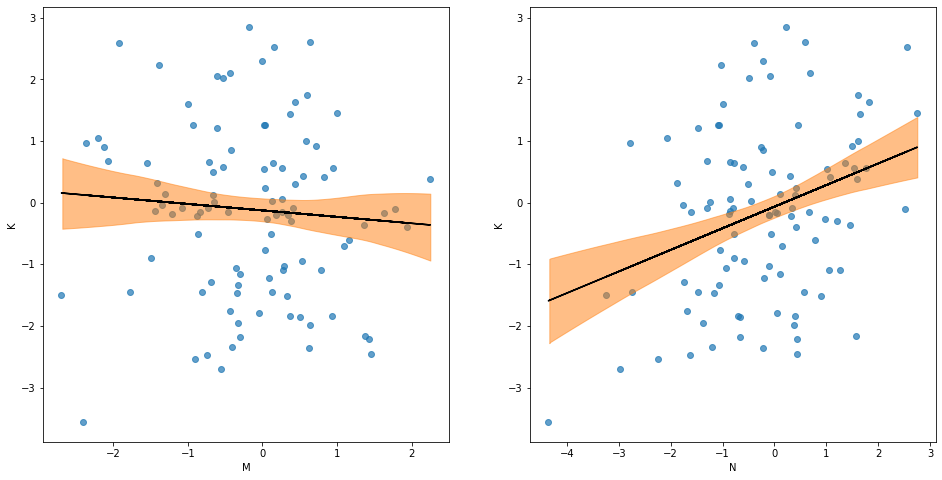

In [11]:
_, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].scatter(df.M, df.K, alpha=0.7)
ax[0].plot(df.M, mk_mu_mean, color='black')
az.plot_hdi(df.M, mk_mu_pred, ax=ax[0], hdi_prob=0.89)
ax[0].set_xlabel('M')
ax[0].set_ylabel('K')

ax[1].scatter(df.N, df.K, alpha=0.7)
ax[1].plot(df.N, nk_mu_mean, color='black')
az.plot_hdi(df.N, nk_mu_pred, ax=ax[1], hdi_prob=0.89)
ax[1].set_xlabel('N')
ax[1].set_ylabel('K')


As we can notice by summaries and the plots above `N` has a correlation coeficient of `0.47` with `K`. However, `M` shows a weak correlation, of `0.23`, to the target `K`.

### Multivariate regression:   M -> K <- N

In [12]:
with pm.Model() as multi_model:
    a = pm.Normal('a', 0, 0.2)
    bN = pm.Normal('bN', 0, 0.5)
    bM = pm.Normal('bM', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
 
    mu = pm.Deterministic('mu', a + bN*df.N + bM*df.M)
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=df['K'])
    
    multi_trace = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bN, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:02<00:00, 4588.22draws/s]


In [13]:
varnames = ['~mu']
az.summary(multi_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,-0.10,0.10,-0.29,0.09
bN,0.79,0.12,0.55,1.01
bM,-0.80,0.16,-1.10,-0.50
sigma,1.16,0.08,1.00,1.31


Notice that in the multivariate regression how the coeficients dramatically increased.
<br>
The two variables `M` and `N` are correlated with `K`, but `M` is negatively correlated while `N` is positively correlated.  
<br>
On the forest plot bellow we can clearly notice the difference on both coeficients from the single variate models to the multivariate one.

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

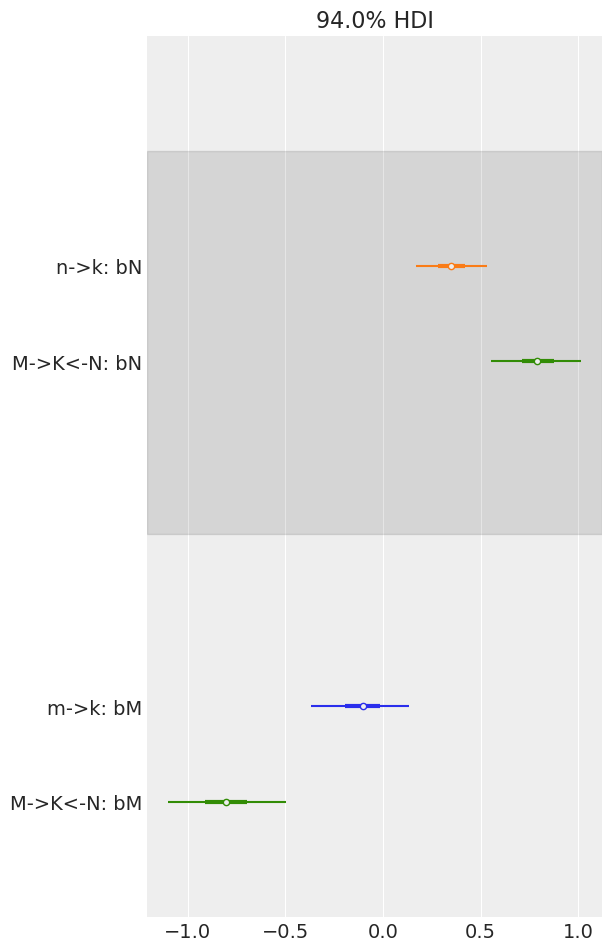

In [14]:
az.style.use("arviz-darkgrid")
az.plot_forest([mk_trace, nk_trace, multi_trace], 
              model_names=["m->k", "n->k", "M->K<-N"],
              var_names=["bN", "bM"],
              combined=True)

The multiple regression model in this case showed a masked correlation of 2 variables with the outcome. In this context one was positively correlated and the other one negatively correlated.

### DAG representation

We can represent the causal relationship with the following DAG(Directed Acyclic Graph):

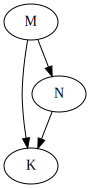

In [15]:
assoc = CausalGraphicalModel(
    nodes=["M", "N", "K"], edges=[("M", "K"), ("N", "K"), ("M", "N")]
)

assoc.draw()

In [16]:
%load_ext watermark
%watermark -iv -v -nuw

pymc3   3.8
arviz   0.10.0
pandas  1.1.1
seaborn 0.10.1
last updated: Sun Nov 01 2020 

CPython 3.7.7
IPython 7.17.0
watermark 2.0.2
